# French Wikipedia, dot model, $\ell_2$-regularized

- dataset: `frwiki`
- model: _dot_
- optimizer: _SGD with decaying learning rate_
- regularization: $\ell_2$

The hyperparameters were found using the `trwiki-[...]-hyperparams` notebooks.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf

from datetime import datetime
from sklearn.metrics import (
    precision_recall_curve, average_precision_score)
from interank import wikiutils
from interank.models import DotModel
from interank.wikidata import WikiData

%matplotlib inline

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## Loading the dataset

In [3]:
%%time
dataset = WikiData("/data/datasets/frwiki")

train_data = dataset.get_train_data()
test_data = dataset.get_test_data()

print("=========")
print("Training set: {} edits".format(len(train_data[0])))
print("Test set: {} edits".format(len(test_data[0])))
print("Number of users: {}".format(dataset.n_users))
print("Number of articles: {}".format(dataset.n_articles))
print("=========")

Training set: 57984080 edits
Test set: 4512971 edits
Number of users: 5574732
Number of articles: 3371084
CPU times: user 1min 59s, sys: 9.68 s, total: 2min 9s
Wall time: 2min 7s


## Setting up the model

- batch size: $5000$
- latent dimensions: $20$
- initial learning rate: $0.1$
- decay rate: $0.7$
- regularization for skills and difficulties: $2.0$
- regularization for latent vectors: $40.0$

The model also includes a global bias, which is not regularized and has a distinct learning rate ($10^{-4}$, decay rate $0.7$).

In [4]:
# Reset graph to run the notebook twice in a row without error.
tf.reset_default_graph()

model = DotModel(
    n_users=dataset.n_users, n_articles=dataset.n_articles,
    n_dims=20, global_bias=True)

# Setup the optimisation procedure
batch_size = 5000
n_batches = math.ceil(len(train_data[0]) / batch_size)
print("Total number of batches: {}".format(n_batches))

# Setup train op.
cost = (-model.log_likelihood
            + (2.0/n_batches) * (model.l2_difficulty + model.l2_skill)
            + (40.0/n_batches) * (model.l2_vec_user + model.l2_vec_article))

# SGD with decaying learning rate.
learning_rate = 0.1
batch_idx_params = tf.Variable(0, trainable=False)
learning_rate_params = tf.train.exponential_decay(
    learning_rate=learning_rate,
    global_step=(batch_idx_params * batch_size),
    decay_steps=len(train_data[0]),
    decay_rate=0.7,
    staircase=True
)
batch_idx_bias = tf.Variable(0, trainable=False)
learning_rate_bias = tf.train.exponential_decay(
    learning_rate=1e-4,
    global_step=(batch_idx_bias * batch_size),
    decay_steps=len(train_data[0]),
    decay_rate=0.7,
    staircase=True
)
train_params = tf.train.GradientDescentOptimizer(learning_rate_params).minimize(
        cost, global_step=batch_idx_params,
        var_list=[model.skill, model.difficulty, model.vec_user, model.vec_article])
train_bias = tf.train.GradientDescentOptimizer(learning_rate_bias).minimize(
        cost, global_step=batch_idx_bias,
        var_list=[model.global_bias])
train_op = tf.group(train_params, train_bias)

# Summaries for Tensorboard
auc_ph = tf.placeholder(tf.float32, name="auc")
tf.summary.scalar("avg_log_loss", model.avg_log_loss)
tf.summary.scalar("area_under_pr_curve", auc_ph)
merged = tf.summary.merge_all()

logdir = '../trained-models/tmp'
folder = "frwiki-dot-regularized_batchsize={}_lr={}_date={}".format(
        batch_size, learning_rate, datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
writer = {
    "train": tf.summary.FileWriter(os.path.join(logdir, folder, "train")),
    "test": tf.summary.FileWriter(os.path.join(logdir, folder, "test")),
}

Total number of batches: 11597


In [5]:
step = 0

feed = {
    "train": {
        model.user_id: train_data[0],
        model.article_id: train_data[1],
        model.quality: train_data[2],
    },
    "test": {
        model.user_id: test_data[0],
        model.article_id: test_data[1],
        model.quality: test_data[2],
    }
}

def evaluate_model(step, bad_edit_threshold=0.5):
    print("### step {}".format(step))
    for which in ("train", "test"):
        avg_log_loss, probs = session.run(
            [model.avg_log_loss, model.probability], feed_dict=feed[which])
        labels = (feed[which][model.quality] < bad_edit_threshold).astype(int)
        auc = average_precision_score(labels, 1 - probs)
        summary = session.run(merged, feed_dict={**feed[which], auc_ph: auc})
        writer[which].add_summary(summary, global_step=step)
        writer[which].flush()
        print("{} set: avg. log-loss = {:.6f}, AUC = {:.3f}".format(
                which, avg_log_loss, auc))

# Initialise Tensorflow's variables
session = tf.Session()
session.run(tf.global_variables_initializer())

# Evalute "empty" model.
evaluate_model(step=step)

### step 0
train set: avg. log-loss = 0.693046, AUC = 0.126
test set: avg. log-loss = 0.693150, AUC = 0.131


## Training the model

In [6]:
%%time
epochs = 10

with session.as_default():
    for i in range(epochs):
        for batch in WikiData.minibatches(train_data, batch_size):
            step += 1
            # Train the model on a batch.
            feed_dict = {
                model.user_id: batch[0],
                model.article_id: batch[1],
                model.quality: batch[2],
            }
            _ = session.run(train_op, feed_dict=feed_dict)


        evaluate_model(step=step)
        print("global bias: {:.3f}".format(model.global_bias.eval()))

### step 11597
train set: avg. log-loss = 0.410078, AUC = 0.456
test set: avg. log-loss = 0.403356, AUC = 0.402
global bias: 0.941
### step 23194
train set: avg. log-loss = 0.404999, AUC = 0.486
test set: avg. log-loss = 0.401815, AUC = 0.409
global bias: 0.934
### step 34791
train set: avg. log-loss = 0.401233, AUC = 0.508
test set: avg. log-loss = 0.401507, AUC = 0.412
global bias: 0.923
### step 46388
train set: avg. log-loss = 0.398197, AUC = 0.523
test set: avg. log-loss = 0.401138, AUC = 0.413
global bias: 0.921
### step 57985
train set: avg. log-loss = 0.395322, AUC = 0.537
test set: avg. log-loss = 0.400842, AUC = 0.414
global bias: 0.921
### step 69582
train set: avg. log-loss = 0.392660, AUC = 0.549
test set: avg. log-loss = 0.400830, AUC = 0.413
global bias: 0.922
### step 81179
train set: avg. log-loss = 0.390462, AUC = 0.560
test set: avg. log-loss = 0.400820, AUC = 0.414
global bias: 0.922
### step 92776
train set: avg. log-loss = 0.388815, AUC = 0.569
test set: avg. log-

## Qualitative results

In [7]:
with session.as_default():
    skills = model.skill.eval()
    difficulties = model.difficulty.eval()
articles = dataset.get_articles()
users = dataset.get_users()

In [8]:
wikiutils.print_articles_summary(difficulties, articles, n=5)

### 5 most difficult articles:
 1 +2.194 Georges Delaw (114 edits, 42 users)
    https://tr.wikipedia.org/wiki/Georges%20Delaw
 2 +2.151 Henri Bouasse (132 edits, 31 users)
    https://tr.wikipedia.org/wiki/Henri%20Bouasse
 3 +2.145 Robertville (Nouveau-Brunswick) (93 edits, 23 users)
    https://tr.wikipedia.org/wiki/Robertville%20%28Nouveau-Brunswick%29
 4 +2.127 Petit-Rocher-Nord (67 edits, 13 users)
    https://tr.wikipedia.org/wiki/Petit-Rocher-Nord
 5 +2.121 Madran (66 edits, 15 users)
    https://tr.wikipedia.org/wiki/Madran

### 5 least difficult articles:
 1 -2.090 Liste de traductrices et traducteurs de littérature germanique (840 edits, 123 users)
    https://tr.wikipedia.org/wiki/Liste%20de%20traductrices%20et%20traducteurs%20de%20litt%C3%A9rature%20germanique
 2 -1.908 Armorial de la Rhénanie-du-Nord-Westphalie (438 edits, 81 users)
    https://tr.wikipedia.org/wiki/Armorial%20de%20la%20Rh%C3%A9nanie-du-Nord-Westphalie
 3 -1.663 Serial Records (167 edits, 96 users)
    htt

In [9]:
wikiutils.print_users_summary(skills, users, n=5)

### 5 most skilled users:
 1 +2.931 Iggy (1500 edits, 1409 articles)
    https://tr.wikipedia.org/wiki/User:Iggy
 2 +2.865 PimpBot (2601 edits, 2536 articles)
    https://tr.wikipedia.org/wiki/User:PimpBot
 3 +2.653 Ousi (393 edits, 262 articles)
    https://tr.wikipedia.org/wiki/User:Ousi
 4 +2.608 Japan Football (2219 edits, 1927 articles)
    https://tr.wikipedia.org/wiki/User:Japan%20Football
 5 +2.600 CactusBot (462 edits, 462 articles)
    https://tr.wikipedia.org/wiki/User:CactusBot

### 5 least skilled users:
 1 -3.332 Toto 351461 (124 edits, 117 articles)
    https://tr.wikipedia.org/wiki/User:Toto%20351461
 2 -2.896 - (357 edits, 357 articles)
    https://tr.wikipedia.org/wiki/User:-
 3 -2.881 - (91 edits, 61 articles)
    https://tr.wikipedia.org/wiki/User:-
 4 -2.861 - (113 edits, 112 articles)
    https://tr.wikipedia.org/wiki/User:-
 5 -2.845 Guy Gauthier (128 edits, 75 articles)
    https://tr.wikipedia.org/wiki/User:Guy%20Gauthier


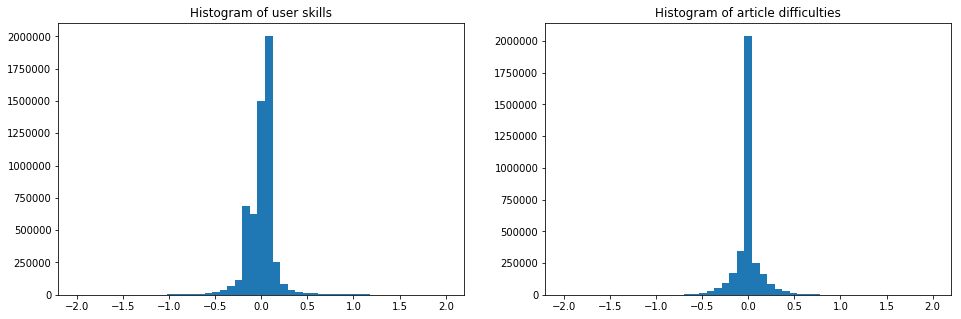

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5), sharex=True)

ax1.hist(skills, bins=np.linspace(-2, 2, num=50))
ax1.set_title("Histogram of user skills")

ax2.hist(difficulties, bins=np.linspace(-2, 2, num=50))
ax2.set_title("Histogram of article difficulties")

In [11]:
with session.as_default():
    probs = model.probability.eval(feed_dict=feed["test"])

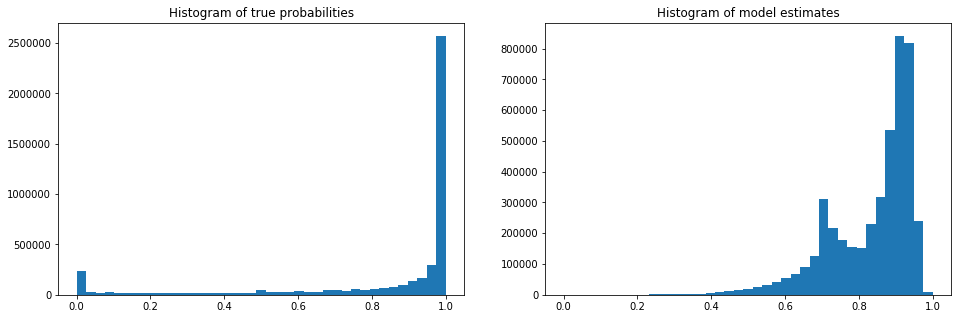

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5), sharex=True)

ax1.hist(test_data[2], bins=np.linspace(0, 1, num=40))
ax1.set_title("Histogram of true probabilities")

ax2.hist(probs, bins=np.linspace(0, 1, num=40))
ax2.set_title("Histogram of model estimates")

## Quantitative results

In [13]:
labels = (test_data[2] < 0.5).astype(int)
precision, recall, _ = precision_recall_curve(labels, 1 - probs)
auc = average_precision_score(labels, 1 - probs)

print("proportion of positive labels: {:.3f}".format(sum(labels) / len(labels)))

proportion of positive labels: 0.131


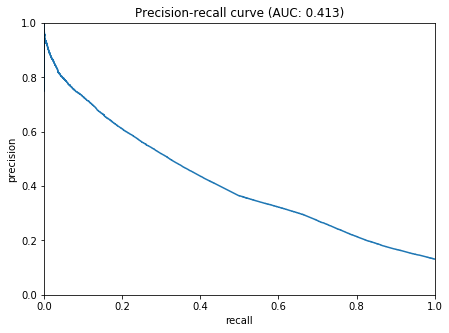

In [14]:
fig, ax = plt.subplots(figsize=(7.0, 5.0))
ax.plot(recall, precision)
ax.set_xlim(xmin=0.0, xmax=1.0)
ax.set_ylim(ymin=0.0, ymax=1.0)
ax.set_ylabel("precision")
ax.set_xlabel("recall")
ax.set_title("Precision-recall curve (AUC: {:.3})".format(auc))

## Save data for plotting, etc.

In [15]:
# Save TensorFlow model
saver = tf.train.Saver()
saver.save(session, "../trained-models/frwiki/dot.ckpt")

'../trained-models/frwiki/dot.ckpt'

In [17]:
data = {
    "y_true": test_data[2],
    "y_pred": probs,
}
with open("../data/frwiki-dot-pred.pickle", "wb") as f:
    pickle.dump(data, f)